# Batch processing with SequenceMap

In this example we will show several examples of batch processing. Batch processing, typically involves applying the same processing steps to each sample in a batch.

This type of processing is often applied during the preprocessing step, where we deal with samples of different sizes, and we process them to form a uniform batch.

First, let us import the packages we need, and load images that we will use in the examples.

In [1]:
import numpy as np  # type: ignore
import onnx
from onnx import parser
from onnx import checker
from onnx import helper
from onnx import TensorProto as tp
from onnx import save
import onnxruntime

Output sizes: 
(400, 266)
(348, 348)


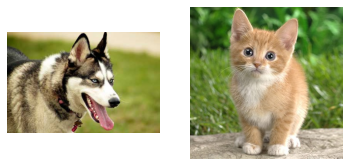

In [2]:
# display images in the notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):
    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].size)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()

images = [
    Image.open('assets/dog.jpg'),
    Image.open('assets/cat.jpg')
]
show_images(images)

## Example 1: Resize to a minimum size, and apply centered crop

In the first example, let us perform some of the most typical preprocessing steps applied to images in image detection applications.

We will first resize the individual images to a minimum target of 256x256, while keeping the original aspect ratio of the image. That is, we will resize the shorter side of the image to 256, and adjust the other side to match the original aspect ratio.

Following the resize operation, we will extract a centered crop of 224x224 from the resized image.

We can express the two operations as the following ONNX graph:

In [3]:
resize_and_crop_sample = parser.parse_model('''
    <
        ir_version: 8,
        opset_import: [ "" : 18, "local" : 1 ]
    >
    process_sample (uint8[H, W, C] image) => (uint8[224, 224, C] image_sliced)
    {
        target_size = Constant <value = int64[2] {256, 256}> ()
        image_resized = Resize <mode = \"linear\",
                                antialias = 1,
                                axes = [0, 1],
                                keep_aspect_ratio_policy = \"not_smaller\"> (image, , , target_size)
    
        target_crop = Constant <value = int64[2] {224, 224}> ()
        image_sliced = CenterCropPad <axes = [0, 1]> (image_resized, target_crop)
    }
    ''')
checker.check_model(resize_and_crop_sample)
onnx.save(resize_and_crop_sample, 'resize_and_crop_image.onnx')

Note that this graph processes a single image at a time, so if we wanted to process several images using this model, we will have to call run image by image. Let us try that to check that our graph works as expected.

Output sizes: 
(224, 224)
(224, 224)


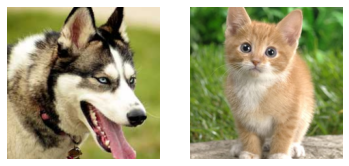

In [4]:
# Using ONNX Runtime to process images individually
session = onnxruntime.InferenceSession('resize_and_crop_image.onnx', None)
out_images = []
for image in images:
    result = session.run([], {'image': np.array(image)})
    out_images.append(Image.fromarray(result[0]))
show_images(out_images)

We are now ready to use the graph we defined together with SequenceMap, to perform batch processing. A non-uniform batch of samples in ONNX can be represented by a sequence of tensors, where each tensor can have a different shape.

SequenceMap operator applies a subgraph (body) to each tensor in the input sequence, producing an output sequence of processed samples. Let us build a model that utilizes SequenceMap to apply the previously created graph to a sequence:

In [5]:
resize_and_crop_batch = parser.parse_model('''
    <
        ir_version: 8,
        opset_import: [ "" : 18 ]
    >
    process_batch (seq(uint8[?, ?, C]) images) => (seq(uint8[224, 224, C]) images_sliced)    
    {
        images_sliced = SequenceMap < 
            body = process_sample (uint8[H, W, C] image) => (uint8[H, W, C] image_sliced)
            {
                target_size = Constant <value = int64[2] {256, 256}> ()
                image_resized = Resize <mode = \"linear\",
                                        antialias = 1,
                                        axes = [0, 1],
                                        keep_aspect_ratio_policy = \"not_smaller\"> (image, , , target_size)
    
                target_crop = Constant <value = int64[2] {224, 224}> ()
                image_sliced = CenterCropPad <axes = [0, 1]> (image_resized, target_crop)
            }
        > (images)
    }
    ''')
checker.check_model(resize_and_crop_batch)
onnx.save(resize_and_crop_batch, 'resize_and_crop_batch.onnx')

With the model saved, we can now create a session and feed several images to a single run call, as a list of numpy array:

Output sizes: 
(224, 224)
(224, 224)


2023-02-08 19:49:18.290806912 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x39ad9e0__0x3ba4150_k2'. It is not used by any node and should be removed from the model.
2023-02-08 19:49:18.290831822 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x39ad9e0__0x3ba4150_axes_input'. It is not used by any node and should be removed from the model.


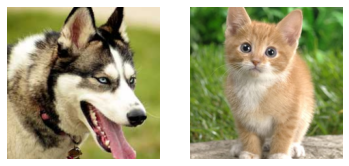

In [6]:
# Using ONNX Runtime to process batches of images in one go
session = onnxruntime.InferenceSession('resize_and_crop_batch.onnx', None)
out_images1 = []
images = [np.array(image) for image in images]
result = session.run([], {'images': images})
out_images = [Image.fromarray(image) for image in result[0]]
show_images(out_images)

## Example 2: Pad images to the size of the largest image

As a second example, we will create a graph that uses two instances of SequenceMap. The first one will be used to extract the shape of each image. We will then concatenate those to a single tensor and use ReduceMax to obtain the maximum canvas dimensions needed to contain every image in the batch. As a last step, we use SequenceMap again to pad each image in the sequence to the calculated canvas size, padding with zeros at the end of each dimension.

In [7]:
pad_to_largest = parser.parse_model('''
    <
        ir_version: 8,
        opset_import: [ "" : 18, "local" : 1 ]
    >
    pad_to_largest (seq(uint8[?, ?, ?]) images) => (seq(uint8[H, W, C]) images_padded)    
    {
        shapes2 = local.get_shapes(images)
        axes = Constant <value = int64[1] {0}> ()
        max_shape = ReduceMax < keepdims = 0 >(shapes2, axes)
        images_padded = SequenceMap < 
            body = pad (uint8[H, W, C] image, int64[3] target_shape) => (uint8[H2, W2, C2] padded_image)
            {
                image_shape = Shape (image)
                diff = Sub (target_shape, image_shape)
                pad_begin = Constant <value = int64[3] {0, 0, 0}> ()
                pads = Concat <axis = 0> (pad_begin, diff)
                padded_image = Pad (image, pads)
            }
        > (images, max_shape)
    }

    <
      opset_import: [ "" : 18 ],
      domain: "local",
      doc_string: "Extract max shape."
    >
    get_shapes (images) => (shapes2) 
    {
        shapes = SequenceMap < 
                body = extract_shape (uint8[H, W, C] image) => (int64[3] image_shape)
                {
                    image_shape = Shape (image)
                }
            >(images)
        shapes2 = ConcatFromSequence < axis = 0, new_axis = 1 >(shapes)
    }
''')
checker.check_model(pad_to_largest)
onnx.save(pad_to_largest, 'pad_to_largest.onnx')

Output sizes: 
(400, 348)
(400, 348)


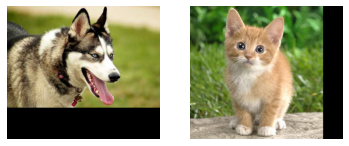

In [8]:
session = onnxruntime.InferenceSession('pad_to_largest.onnx', None)
out_images1 = []
images = [np.array(image) for image in images]
result = session.run([], {'images': images})
out_images = [Image.fromarray(image) for image in result[0]]
show_images(out_images)

## Example 3: ResNet-50 preprocessing pipeline

The last example is meant to show how SequenceMap could be used in an ONNX graph to represent the data preprocessing steps of a graph, before feeding the data to the neural network, avoiding thus the Python preprocessing steps typically required.

A ResNet preprocessing pipeline for inference involves the resize and crop operations that we presented in Example 1, followed by a normalization step, and a transposition to a channel-first layout. Let us represent that with an ONNX graph:

In [9]:
rn50_preprocessing_model = parser.parse_model('''
    <
      ir_version: 8,
      opset_import: [ "" : 18, "local" : 1 ]
    >
    agraph (seq(uint8[?, ?, 3]) images) => (float[B, 3, 224, 224] output)
    {
        output = local.preprocess(images)
    }

    <
      opset_import: [ "" : 18 ],
      domain: "local",
      doc_string: "Preprocessing function."
    >
    preprocess (input_batch) => (output_tensor) {
        tmp_seq = SequenceMap < 
            body = g(uint8[H, W, 3] sample_in) => (float[3, 224, 224] sample_out) {
                target_size = Constant <value = int64[2] {256, 256}> ()
                image_resized = Resize <mode = \"linear\",
                                        antialias = 1,
                                        axes = [0, 1],
                                        keep_aspect_ratio_policy = \"not_smaller\"> (sample_in, , , target_size)

                target_crop = Constant <value = int64[2] {224, 224}> ()
                image_sliced = CenterCropPad <axes = [0, 1]> (image_resized, target_crop)

                kMean = Constant <value = float[3] {123.675, 116.28, 103.53}> ()
                kStddev = Constant <value = float[3] {58.395, 57.12, 57.375}> ()
                im_norm_tmp1 = Cast <to = 1> (image_sliced)
                im_norm_tmp2 = Sub (im_norm_tmp1, kMean)
                im_norm = Div (im_norm_tmp2, kStddev)

                sample_out = Transpose <perm = [2, 0, 1]> (im_norm) 
            }
        > (input_batch)
        output_tensor = ConcatFromSequence < axis = 0, new_axis = 1 >(tmp_seq)
    }
''')
checker.check_model(rn50_preprocessing_model)
onnx.save(rn50_preprocessing_model, 'rn50_preprocessing.onnx')

We can now run the model, and verify that we get data with dimensions (N, 3, 224, 224), where N represents the number of samples in the input sequence

In [10]:
session = onnxruntime.InferenceSession('rn50_preprocessing.onnx', None)
out_images1 = []
images = [np.array(image) for image in images]
result = session.run([], {'images': images})
data = result[0]
print("Tensor shape: ", data.shape)

Tensor shape:  (2, 3, 224, 224)


2023-02-08 19:49:18.565258146 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x3bcc2a0__0x3ba4150_axes_input'. It is not used by any node and should be removed from the model.
2023-02-08 19:49:18.565277632 [W:onnxruntime:, graph.cc:3490 CleanUnusedInitializersAndNodeArgs] Removing initializer '_0x3bcc2a0__0x3ba4150_k2'. It is not used by any node and should be removed from the model.


As an exercise, and for the sake of visualization, let us manipulate the resulting tensor to a 3D array that can be displayed as an image. First restoring the original channel-last layout, then concatenating the data from the two images side by side.

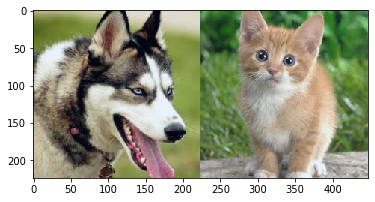

In [11]:
from matplotlib import pyplot as plt

def visualize_processed_batch(data):
    samples = []
    for i in range(data.shape[0]):
        samples.append(np.transpose(data[i], axes=[1, 2, 0]))
    data_plot = np.concatenate(samples, axis=1)

    def scale(A):
        return (A-np.min(A))/(np.max(A) - np.min(A))
    data_plot = scale(data_plot)
    plt.imshow(data_plot, interpolation='nearest')    

visualize_processed_batch(data)